In [55]:
import matplotlib.pyplot as plt

def init_board():
  return jnp.zeros((4, 4), dtype=int)

def flip_board(board):
  return -board

def valid_mask(board):
  return board == 0

#Always assume action is made by player 1
def next_state(board, action):
  return board.flatten().at[action].add(1).reshape(board.shape)

def sample_action(action_dist, rng):
  action_dist = action_dist.flatten() / action_dist.sum()
  return jax.random.choice(rng, jnp.arange(action_dist.shape[0]), p=action_dist)

def disp_board(board):
  plt.imshow(board)

reward_conv = nn.Conv(features=3, kernel_size=(3, 3), use_bias=False, padding='SAME')
stripe_filter = jnp.array([[0, 0, 0], [1, 1, 1], [0, 0, 0]])
conv_param = {'params': {'kernel': jnp.expand_dims(jnp.stack([jnp.eye(3), stripe_filter, stripe_filter.T]), 2)}}

def get_reward(board, conv_param):
    board_score = reward_conv.apply(conv_param, jnp.expand_dims(board, (0, 3)))
    is_win = (jnp.max(board_score) >= 3).astype(int)
    is_loss = (jnp.min(board_score) <= -3).astype(int)
    return is_win - is_loss

Round 0
[[ 0  0 -1  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]]
0
Round 1
[[ 0  0  1  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [-1  0  0  0]]
0
Round 2
[[ 0  0 -1  0]
 [ 0 -1  0  0]
 [ 0  0  0  0]
 [ 1  0  0  0]]
0
Round 3
[[ 0  0  1  0]
 [-1  1  0  0]
 [ 0  0  0  0]
 [-1  0  0  0]]
0
Round 4
[[ 0 -1 -1  0]
 [ 1 -1  0  0]
 [ 0  0  0  0]
 [ 1  0  0  0]]
0
Round 5
[[ 0  1  1  0]
 [-1  1  0  0]
 [ 0  0  0  0]
 [-1  0  0 -1]]
0
Round 6
[[ 0 -1 -1 -1]
 [ 1 -1  0  0]
 [ 0  0  0  0]
 [ 1  0  0  1]]
0
Round 7
[[ 0  1  1  1]
 [-1  1  0  0]
 [ 0  0  0 -1]
 [-1  0  0 -1]]
0
Round 8
[[ 0 -1 -1 -1]
 [ 1 -1  0  0]
 [ 0  0  0  1]
 [ 1 -1  0  1]]
0
Round 9
[[ 0  1  1  1]
 [-1  1  0  0]
 [-1  0  0 -1]
 [-1  1  0 -1]]
0


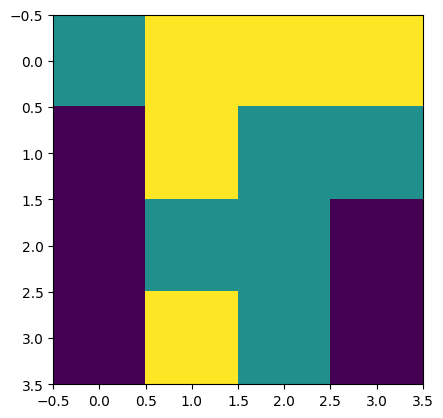

In [56]:
board = init_board()

rng = jax.random.PRNGKey(41)
for i in range(10):
  _, rng = jax.random.split(rng, 2)
  action_dist = jnp.ones(board.shape) * valid_mask(board)
  next_action = sample_action(action_dist, rng)
  board = flip_board(next_state(board, next_action))
  print(f"Round {i}")
  print(board)
  reward = get_reward(board, conv_param)
  print(reward)
  if(reward != 0):
      break
  
disp_board(board)

In [32]:
import jax
import jax.numpy as jnp                # JAX NumPy

from flax import linen as nn           # The Linen API
from flax import traverse_util
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np                     # Ordinary NumPy
import optax                           # Optimizers

In [31]:


rng = jax.random.PRNGKey(42)
rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp = jnp.zeros((10, 10, 1))

# params = conv.init(init_rng, inp)
# print(jax.tree_util.tree_map(jnp.shape, params))




(10, 10, 3)

In [ ]:
class CNN(nn.Module):
  """A simple CNN model."""

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    return x

cnn = CNN()
params = cnn.init(rng, jnp.ones([1, 28, 28, 1]))['params']